In [1]:
# Install required packages
!pip install torch torchvision matplotlib scikit-learn opendatasets -q

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import opendatasets as od
import shutil
from sklearn.model_selection import train_test_split

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================
# DATASET DOWNLOAD CODE ONLY
# ============================================
print("="*50)
print("DOWNLOADING DATASET FROM KAGGLE")
print("="*50)
print("Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2")
print("="*50)

# Step 1: Download dataset from Kaggle using opendatasets
dataset_url = "https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2"
try:
    # Download dataset
    od.download(dataset_url)
    print("Dataset downloaded successfully!")

    # The dataset will be downloaded to a folder named after the dataset
    dataset_folder = "garbage-classification-v2"

    # Check what's inside the downloaded folder
    print("\nContents of downloaded folder:")
    print(os.listdir(dataset_folder))

    # Step 2: Organize the dataset into train/val/test structure
    def organize_garbage_dataset(source_folder, target_folder="garbage_data"):
        """
        Organize the garbage classification dataset into proper structure
        """
        os.makedirs(target_folder, exist_ok=True)

        # Check the structure of the downloaded dataset
        for item in os.listdir(source_folder):
            item_path = os.path.join(source_folder, item)
            if os.path.isdir(item_path):
                print(f"Found directory: {item}")

                # Look for class folders
                subfolders = [f for f in os.listdir(item_path) if os.path.isdir(os.path.join(item_path, f))]
                if subfolders:
                    print(f"  Contains class folders: {subfolders}")

                    # Check if this is already split (train/test/val)
                    if any(x in item.lower() for x in ['train', 'test', 'val']):
                        # Copy the split structure directly
                        split_dir = os.path.join(target_folder, item.lower())
                        shutil.copytree(item_path, split_dir, dirs_exist_ok=True)
                        print(f"  Copied {item} to {split_dir}")
                    else:
                        # This might be the main data folder with all classes
                        # We need to create train/val/test splits
                        create_train_val_test_split(item_path, target_folder)
                else:
                    print(f"  No subfolders found in {item}")

        return target_folder

    def create_train_val_test_split(data_folder, target_base, train_ratio=0.60, val_ratio=0.20, test_ratio=0.20):
        """
        Create train/val/test split from a folder containing class folders
        """
        # Create split directories
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(target_base, split), exist_ok=True)

        # Get all class folders
        classes = [d for d in os.listdir(data_folder)
                  if os.path.isdir(os.path.join(data_folder, d))]

        print(f"\nCreating splits for {len(classes)} classes...")

        for class_name in classes:
            class_path = os.path.join(data_folder, class_name)

            # Get all images in class folder
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

            if not images:
                print(f"  Warning: No images found in {class_name}")
                continue

            # Create class folders in each split
            for split in ['train', 'val', 'test']:
                os.makedirs(os.path.join(target_base, split, class_name), exist_ok=True)

            # Split images
            train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio, random_state=42)
            val_imgs, test_imgs = train_test_split(temp_imgs, train_size=val_ratio/(val_ratio+test_ratio), random_state=42)

            # Copy images to respective folders
            for img in train_imgs:
                src = os.path.join(class_path, img)
                dst = os.path.join(target_base, 'train', class_name, img)
                shutil.copy2(src, dst)

            for img in val_imgs:
                src = os.path.join(class_path, img)
                dst = os.path.join(target_base, 'val', class_name, img)
                shutil.copy2(src, dst)

            for img in test_imgs:
                src = os.path.join(class_path, img)
                dst = os.path.join(target_base, 'test', class_name, img)
                shutil.copy2(src, dst)

            print(f"  {class_name}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")

        print("\nDataset split created successfully!")

    # Step 3: Organize the dataset
    print("\nOrganizing dataset structure...")
    output_directory = organize_garbage_dataset(dataset_folder)

    # Step 4: Check if we need to create splits
    if not all(os.path.exists(os.path.join(output_directory, split)) for split in ['train', 'val', 'test']):
        print("\nDataset not properly structured. Creating train/val/test splits...")

        # Find the folder containing class folders
        for item in os.listdir(dataset_folder):
            item_path = os.path.join(dataset_folder, item)
            if os.path.isdir(item_path):
                # Check if this folder contains class folders (not split folders)
                subfolders = [f for f in os.listdir(item_path) if os.path.isdir(os.path.join(item_path, f))]
                if subfolders and not any(x in item.lower() for x in ['train', 'test', 'val']):
                    create_train_val_test_split(item_path, output_directory)
                    break

    print(f"\nDataset organized at: {output_directory}")

except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("\nTrying alternative download method...")

    # Alternative method: Use direct download if opendatasets fails
    !pip install kaggle -q

    # Setup Kaggle API (you'll need to upload your kaggle.json)
    from google.colab import files
    print("Please upload your kaggle.json file:")
    files.upload()

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download dataset using Kaggle API
    !kaggle datasets download -d sumn2u/garbage-classification-v2
    !unzip -q garbage-classification-v2.zip -d garbage_data

    output_directory = "garbage_data"

    # Create splits if needed
    if not all(os.path.exists(os.path.join(output_directory, split)) for split in ['train', 'val', 'test']):
        create_train_val_test_split(output_directory, output_directory)

Using device: cuda
DOWNLOADING DATASET FROM KAGGLE
Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Peter Raafat
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2


100%|██████████| 744M/744M [00:03<00:00, 206MB/s] 



Dataset downloaded successfully!

Contents of downloaded folder:
['garbage-dataset']

Organizing dataset structure...
Found directory: garbage-dataset
  Contains class folders: ['metal', 'battery', 'shoes', 'glass', 'biological', 'clothes', 'trash', 'plastic', 'paper', 'cardboard']

Creating splits for 10 classes...
  metal: 612 train, 204 val, 204 test
  battery: 566 train, 189 val, 189 test
  shoes: 1186 train, 395 val, 396 test
  glass: 1836 train, 612 val, 613 test
  biological: 598 train, 199 val, 200 test
  clothes: 3196 train, 1065 val, 1066 test
  trash: 568 train, 189 val, 190 test
  plastic: 1190 train, 397 val, 397 test
  paper: 1008 train, 336 val, 336 test
  cardboard: 1095 train, 365 val, 365 test

Dataset split created successfully!

Dataset organized at: garbage_data



Loading datasets...

Dataset Information:
Number of classes: 10
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Training images: 11855
Validation images: 3951
Test images: 3956


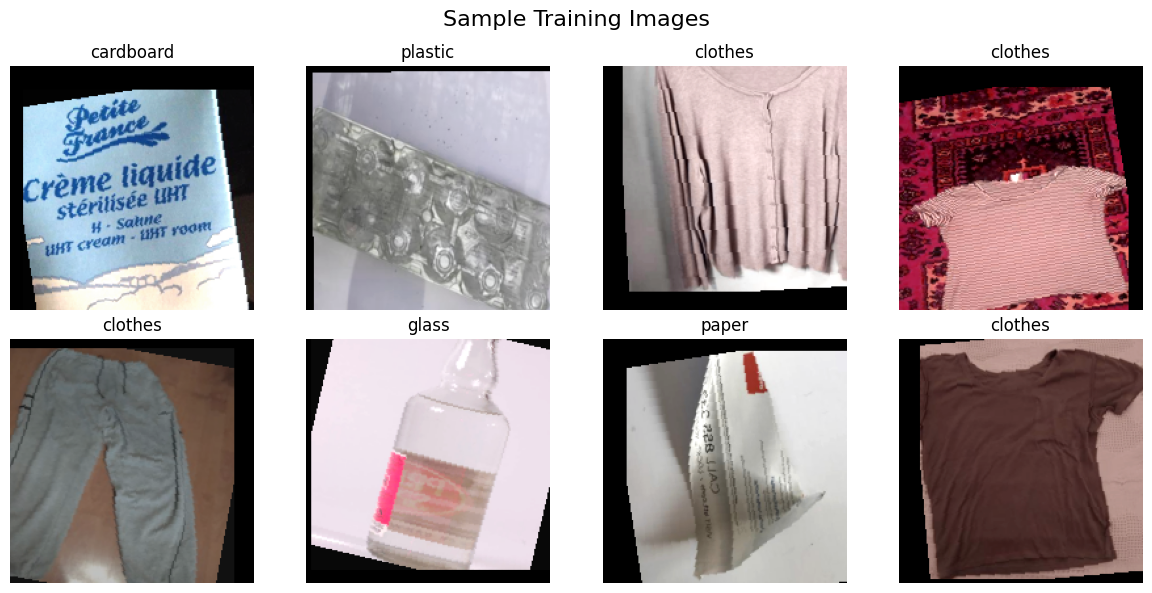

In [2]:
# STEP 3: Define transforms and create dataloaders
# ============================================
# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop((186, 186)),
    transforms.RandomHorizontalFlip(0.4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.456, 0.456, 0.456],
                        std=[0.225, 0.225, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.456, 0.456, 0.456],
                        std=[0.225, 0.225, 0.225])
])

# Load datasets
print("\nLoading datasets...")
train_dataset = datasets.ImageFolder(
    os.path.join(output_directory, 'train'),
    transform=train_transform
)
val_dataset = datasets.ImageFolder(
    os.path.join(output_directory, 'val'),
    transform=val_transform
)
test_dataset = datasets.ImageFolder(
    os.path.join(output_directory, 'test'),
    transform=val_transform
)

# Create dataloaders
batch_size = 32  # Reduced for Colab memory constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Get class information
class_names = train_dataset.classes
num_classes = len(class_names)

print(f"\nDataset Information:")
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

# Visualize some training images
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx, ax in enumerate(axes):
        image, label = dataset[indices[idx]]
        # Convert tensor to numpy for display
        image_np = image.numpy().transpose((1, 2, 0))
        # Denormalize
        mean = np.array([0.456, 0.456, 0.456])
        std = np.array([0.225, 0.225, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)

        ax.imshow(image_np)
        ax.set_title(f"{class_names[label]}")
        ax.axis('off')

    plt.suptitle('Sample Training Images', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)

In [3]:
# STEP 4: Define the model
# ============================================
class GarbageClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.7):
        super(GarbageClassifier, self).__init__()

        # Use ResNet50 as backbone
        self.backbone = models.resnet50(pretrained=True)

        # Freeze early layers
        layer_count = 0
        total_layers = sum(1 for _ in self.backbone.parameters())
        print(f"Total layers in ResNet50: {total_layers}")

        for param in self.backbone.parameters():
            if layer_count < 64:  # Freeze first 64 layers
                param.requires_grad = False
            layer_count += 1

        num_features = self.backbone.fc.in_features

        # Custom classifier head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Create model
model = GarbageClassifier(num_classes=num_classes)
model = model.to(device)

print("\nModel architecture:")
print(model)

# Count parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nParameter Information:")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


Total layers in ResNet50: 161

Model architecture:
GarbageClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): R


Starting training process...

Starting training...
Epoch [1/30]
Train Loss: 1.2661, Train Acc: 59.28%
Val Accuracy: 82.81%
Gap (Overfitting): -23.53%
Current LR: 0.000100
--------------------------------------------------
New best model saved with val accuracy: 82.81%
Epoch [2/30]
Train Loss: 0.5955, Train Acc: 83.84%
Val Accuracy: 91.50%
Gap (Overfitting): -7.66%
Current LR: 0.000100
--------------------------------------------------
New best model saved with val accuracy: 91.50%
Epoch [3/30]
Train Loss: 0.4403, Train Acc: 87.74%
Val Accuracy: 93.93%
Gap (Overfitting): -6.18%
Current LR: 0.000100
--------------------------------------------------
New best model saved with val accuracy: 93.93%
Epoch [4/30]
Train Loss: 0.3539, Train Acc: 90.08%
Val Accuracy: 93.87%
Gap (Overfitting): -3.79%
Current LR: 0.000100
--------------------------------------------------
Early stopping counter: 1/10
Epoch [5/30]
Train Loss: 0.3226, Train Acc: 91.01%
Val Accuracy: 94.15%
Gap (Overfitting): -3.15%

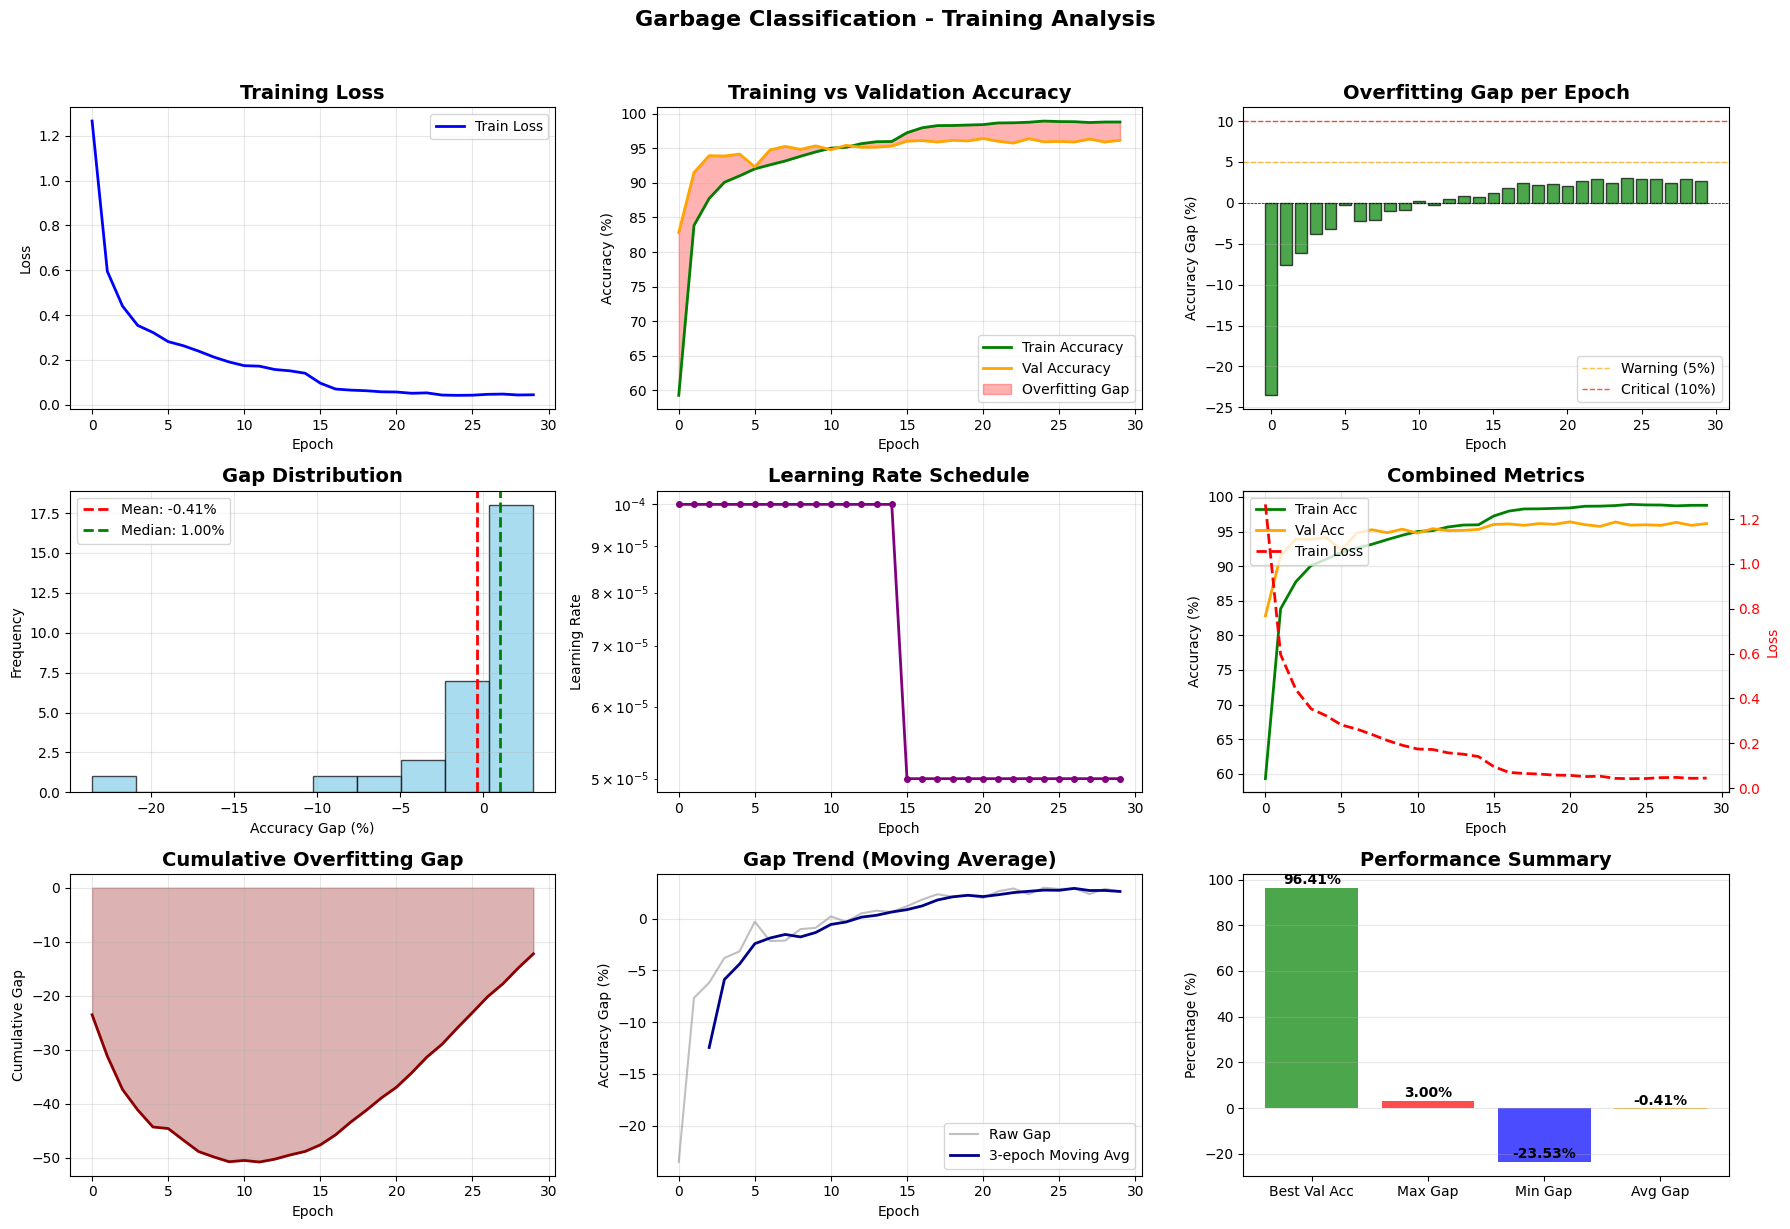

In [4]:
# STEP 5: Training functions
# ============================================
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train_advanced_model(model, train_loader, val_loader, epochs=50):
    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    # Early stopping
    best_val_acc = 0
    patience = 10
    patience_counter = 0

    # Track metrics
    train_losses = []
    val_accuracies = []
    train_accuracies = []
    gaps = []
    learning_rates = []

    print("\nStarting training...")
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_accuracies.append(train_acc)
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        val_acc = validate_model(model, val_loader)
        val_accuracies.append(val_acc)

        # Calculate gap
        gap = train_acc - val_acc
        gaps.append(gap)

        # Track learning rate
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Update scheduler
        scheduler.step()

        # Print progress
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Accuracy: {val_acc:.2f}%')
        print(f'Gap (Overfitting): {gap:.2f}%')
        print(f'Current LR: {learning_rates[-1]:.6f}')
        print('-' * 50)

        # Early stopping and model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), '/content/best_Garbage_Classifier.pth')
            print(f"New best model saved with val accuracy: {val_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"Early stopping counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load the best model
    if os.path.exists('/content/best_Garbage_Classifier.pth'):
        model.load_state_dict(torch.load('/content/best_Garbage_Classifier.pth'))

    print(f"\nTraining completed. Best validation accuracy: {best_val_acc:.2f}%")

    return train_losses, val_accuracies, train_accuracies, gaps, learning_rates
print("\n" + "="*50)
print("Starting training process...")
print("="*50)

train_losses, val_accuracies, train_accuracies, gaps, learning_rates = train_advanced_model(
    model, train_loader, val_loader, epochs=30  # Reduced epochs for Colab
)
# STEP 7: Visualization
# ============================================
print("\nGenerating visualizations...")

# Create comprehensive visualization
plt.figure(figsize=(18, 12))

# 1. Training Loss
plt.subplot(3, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Accuracy Comparison
plt.subplot(3, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green', linewidth=2)
plt.plot(val_accuracies, label='Val Accuracy', color='orange', linewidth=2)
plt.fill_between(range(len(train_accuracies)), train_accuracies, val_accuracies,
                 alpha=0.3, color='red', label='Overfitting Gap')
plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Overfitting Gap
plt.subplot(3, 3, 3)
colors = ['red' if g > 10 else 'orange' if g > 5 else 'green' for g in gaps]
plt.bar(range(len(gaps)), gaps, color=colors, edgecolor='black', alpha=0.7)
plt.axhline(y=0, color='black', linewidth=0.5, linestyle='--')
plt.axhline(y=5, color='orange', linewidth=1, linestyle='--', alpha=0.7, label='Warning (5%)')
plt.axhline(y=10, color='red', linewidth=1, linestyle='--', alpha=0.7, label='Critical (10%)')
plt.title('Overfitting Gap per Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap (%)')
plt.grid(True, alpha=0.3, axis='y')
plt.legend()

# 4. Gap Distribution
plt.subplot(3, 3, 4)
plt.hist(gaps, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=np.mean(gaps), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(gaps):.2f}%')
plt.axvline(x=np.median(gaps), color='green', linestyle='--', linewidth=2,
            label=f'Median: {np.median(gaps):.2f}%')
plt.title('Gap Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Accuracy Gap (%)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()

# 5. Learning Rate Schedule
plt.subplot(3, 3, 5)
plt.plot(learning_rates, color='purple', linewidth=2, marker='o', markersize=4)
plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# 6. Combined Metrics
plt.subplot(3, 3, 6)
ax1 = plt.gca()
ax1.plot(train_accuracies, color='green', linewidth=2, label='Train Acc')
ax1.plot(val_accuracies, color='orange', linewidth=2, label='Val Acc')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(train_losses, color='red', linewidth=2, linestyle='--', label='Train Loss')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Combined Metrics', fontsize=14, fontweight='bold')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 7. Cumulative Gap
plt.subplot(3, 3, 7)
cumulative_gap = np.cumsum(gaps)
plt.plot(range(len(cumulative_gap)), cumulative_gap, color='darkred', linewidth=2)
plt.fill_between(range(len(cumulative_gap)), cumulative_gap, alpha=0.3, color='darkred')
plt.title('Cumulative Overfitting Gap', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Cumulative Gap')
plt.grid(True, alpha=0.3)

# 8. Moving Average of Gap
plt.subplot(3, 3, 8)
window_size = 3
if len(gaps) >= window_size:
    moving_avg = np.convolve(gaps, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(len(gaps)), gaps, color='gray', alpha=0.5, label='Raw Gap')
    plt.plot(range(window_size-1, len(gaps)), moving_avg, color='darkblue',
             linewidth=2, label=f'{window_size}-epoch Moving Avg')
else:
    plt.plot(gaps, color='darkblue', linewidth=2)
plt.title('Gap Trend (Moving Average)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap (%)')
plt.grid(True, alpha=0.3)
plt.legend()

# 9. Performance Summary
plt.subplot(3, 3, 9)
metrics = ['Best Val Acc', 'Max Gap', 'Min Gap', 'Avg Gap']
values = [
    f'{max(val_accuracies):.2f}%',
    f'{max(gaps):.2f}%',
    f'{min(gaps):.2f}%',
    f'{np.mean(gaps):.2f}%'
]

colors_metric = ['green', 'red', 'blue', 'orange']
bars = plt.bar(metrics, [float(v.strip('%')) for v in values], color=colors_metric, alpha=0.7)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5, val,
             ha='center', va='bottom', fontweight='bold')

plt.title('Performance Summary', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

# Add overall title
plt.suptitle('Garbage Classification - Training Analysis', fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('/content/training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


Evaluating model on test set...
Test Accuracy: 95.98%

Classification Report:
              precision    recall  f1-score   support

     battery     0.9590    0.9894    0.9740       189
  biological     0.9749    0.9700    0.9724       200
   cardboard     0.9276    0.9836    0.9548       365
     clothes     0.9972    0.9850    0.9910      1066
       glass     0.9487    0.9657    0.9572       613
       metal     0.9020    0.9020    0.9020       204
       paper     0.9541    0.9286    0.9412       336
     plastic     0.9573    0.9043    0.9301       397
       shoes     0.9532    0.9773    0.9651       396
       trash     0.9301    0.9105    0.9202       190

    accuracy                         0.9598      3956
   macro avg     0.9504    0.9516    0.9508      3956
weighted avg     0.9601    0.9598    0.9597      3956



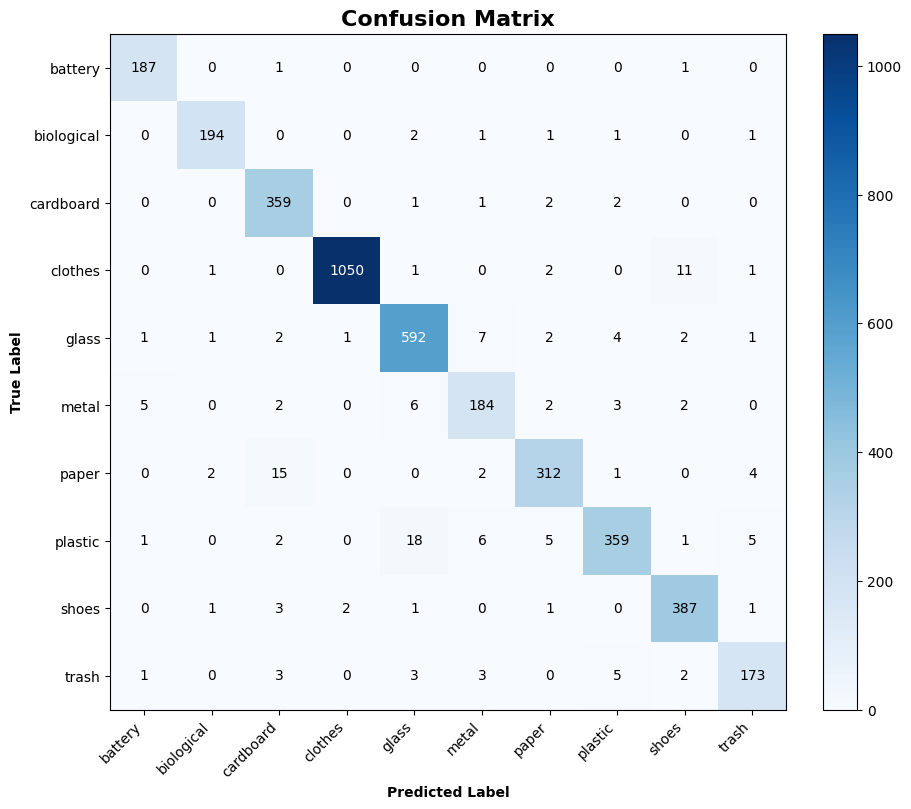

In [5]:
# STEP 8: Evaluation
# ============================================
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions,
                              target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.colorbar(fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    return accuracy, all_predictions, all_labels

print("\n" + "="*50)
print("Evaluating model on test set...")
print("="*50)

test_accuracy, all_preds, all_labels = evaluate_model(model, test_loader, class_names)



Final model saved at: /content/final_Garbage_Classification.pth
Best validation accuracy: 96.41%
Test accuracy: 95.98%

Generating per-class accuracy plot...


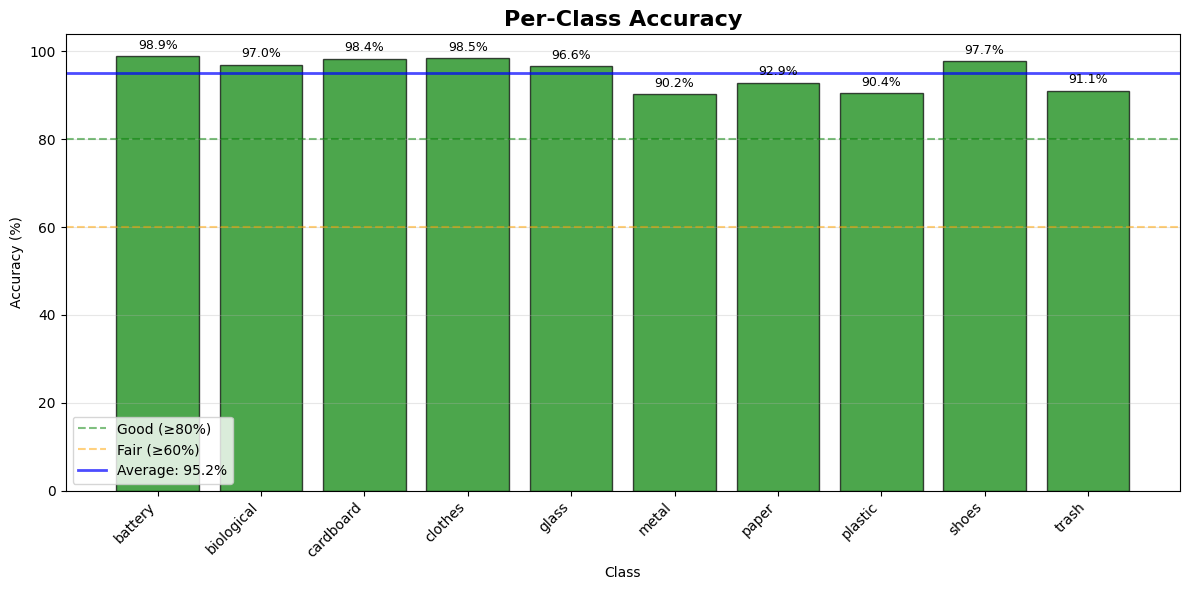

In [6]:
# STEP 9: Save final model
# ============================================
# Save the complete model info
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'num_classes': num_classes,
    'test_accuracy': test_accuracy,
    'train_losses': train_losses,
    'val_accuracies': val_accuracies,
    'train_accuracies': train_accuracies,
    'gaps': gaps
}, '/content/final_Garbage_Classification.pth')

print(f"\nFinal model saved at: /content/final_Garbage_Classification.pth")
print(f"Best validation accuracy: {max(val_accuracies):.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

# ============================================
# STEP 10: Additional visualizations
# ============================================
# Per-class accuracy
def plot_per_class_accuracy(all_labels, all_preds, class_names):
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)

    for label, pred in zip(all_labels, all_preds):
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1

    class_accuracies = [100 * correct / total if total > 0 else 0
                       for correct, total in zip(class_correct, class_total)]

    plt.figure(figsize=(12, 6))
    colors = ['green' if acc >= 80 else 'orange' if acc >= 60 else 'red' for acc in class_accuracies]
    bars = plt.bar(range(len(class_names)), class_accuracies, color=colors, alpha=0.7, edgecolor='black')

    plt.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='Good (≥80%)')
    plt.axhline(y=60, color='orange', linestyle='--', alpha=0.5, label='Fair (≥60%)')
    plt.axhline(y=np.mean(class_accuracies), color='blue', linestyle='-',
                alpha=0.7, linewidth=2, label=f'Average: {np.mean(class_accuracies):.1f}%')

    plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1, f'{acc:.1f}%',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('/content/per_class_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nGenerating per-class accuracy plot...")
plot_per_class_accuracy(all_labels, all_preds, class_names)

In [7]:
# STEP 11: Download trained model files
# ============================================
print("\n" + "="*50)
print("Download links for trained models:")
print("="*50)
print("Best model (by validation accuracy):")
print("!cp /content/best_Garbage_Classifier.pth /content/drive/MyDrive/")  # If using Google Drive
print("\nFinal model with all info:")
print("!cp /content/final_Garbage_Classification.pth /content/drive/MyDrive/")
print("\nVisualizations:")
print("!cp /content/training_analysis.png /content/drive/MyDrive/")
print("!cp /content/confusion_matrix.png /content/drive/MyDrive/")
print("!cp /content/per_class_accuracy.png /content/drive/MyDrive/")

print("\n" + "="*50)
print("Training and evaluation complete!")
print("="*50)


Download links for trained models:
Best model (by validation accuracy):
!cp /content/best_Garbage_Classifier.pth /content/drive/MyDrive/

Final model with all info:
!cp /content/final_Garbage_Classification.pth /content/drive/MyDrive/

Visualizations:
!cp /content/training_analysis.png /content/drive/MyDrive/
!cp /content/confusion_matrix.png /content/drive/MyDrive/
!cp /content/per_class_accuracy.png /content/drive/MyDrive/

Training and evaluation complete!
